# Tutorial 3: Setting up a farm calculation

In [1]:
# Note: this python notebook was automatically generated by make_tutorial3.py

# Load the amrwind-frontend module
amrwindfedir = '../../'  # Location of amrwind-frontend directory
import sys, os
sys.path.insert(1, amrwindfedir)

# Load the libraries
import amrwind_frontend as amrwind
import matplotlib.pyplot    as plt

# Also ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Make all plots inline 
%matplotlib inline

In [2]:
# Start the AMR-Wind case
case = amrwind.MyApp.init_nogui()


## Introduction

This tutorial will demonstrate the following features: 
- How to set up a wind farm layout with multiple turbines using
  `amrwind-frontend`.
- How to run a parameter sweep over wind speed and wind direction, and
  have `amrwind-frontend` generate the necessary input files for each
  case.



## Set some wind properties

For the purposes of demonstrating how to setup a wind farm layout,
we'll start with some arbitrary wind speed and wind direction values.
The exact values don't really matter, as later on in the tutorial,
we'll change these values, but for now they'll be useful when plotting
the results.

Below we'll use a wind speed of 10 m/s and wind direction of 225
degrees.


In [3]:
case.setAMRWindInput('useWSDir', True)
case.setAMRWindInput('ABL_windspeed', 10.0, forcechange=True)
case.setAMRWindInput('ABL_winddir', 225.0, forcechange=True)
case.ABL_calculateWindVector()

In [4]:
case.setAMRWindInput('incflo.physics', ['FreeStream', 'Actuator'])
case.setAMRWindInput('time.fixed_dt', 0.25)

## Create wind farm layout and domain

We'll use a CSV format to provde the turbine layout information.  This
will generally take the form of something like 

```
# CSV file should have columns with
# name, x, y, type, yaw, hubheight, options
T0, 480, 280, UnifCtTest, , ,
T1, 480, 680, UnifCtTest, , ,
```

Here's what each of the columns mean:

### TURBINE LAYOUT SPECIFICATIONS

| column      | description                                                                       | required/optional |
| ---         | ---                                                                               | ---               |
| `name`      | The name of the turbine (can be arbitrary).                                       | required          |
| `x`         | The x position of the turbine.                                                    | required          |
| `y`         | The y position of the turbine.                                                    | required          |
| `type`      | The turbine type (must be listed under turbine types tab)                         | required          |
| `yaw`       | The turbine yaw heading.  If not specified, turbine points directly into the wind | optional          |
| `hubheight` | The turbine hub-height.  If not specified, uses the default from the turbine type | optional          |
| `options`   | Optional parameters                                                               | optional          |



In [5]:
turbinescsv="""
# CSV file should have columns with
# name, x, y, type, yaw, hubheight, options
T0, 480, 280, UnifCtTest, , ,
T1, 480, 680, UnifCtTest, , ,
"""
case.setAMRWindInput('turbines_csvtextbox',  turbinescsv)

Note that if you already have a csv file saved somewhere, you can load that directly using the `loadTurbineCSVFile()` command, like
```python
case.loadTurbineCSVFile('turbines.csv')
```
instead of using `setAMRWindInput()` to set the variable directly.

We'll also need to set some thing things like the turbine domainsize
of `[960, 960, 960]` and background mesh size of `10`m.

In [6]:
case.setAMRWindInput('turbines_domainsize', [960.0, 960.0, 960.0])
case.setAMRWindInput('turbines_backgroundmeshsize', 10.0)
case.setAMRWindInput('turbines_deleteprev', True)

You can preview the locations and domain size using the `turbines_previewAllTurbines() command:`

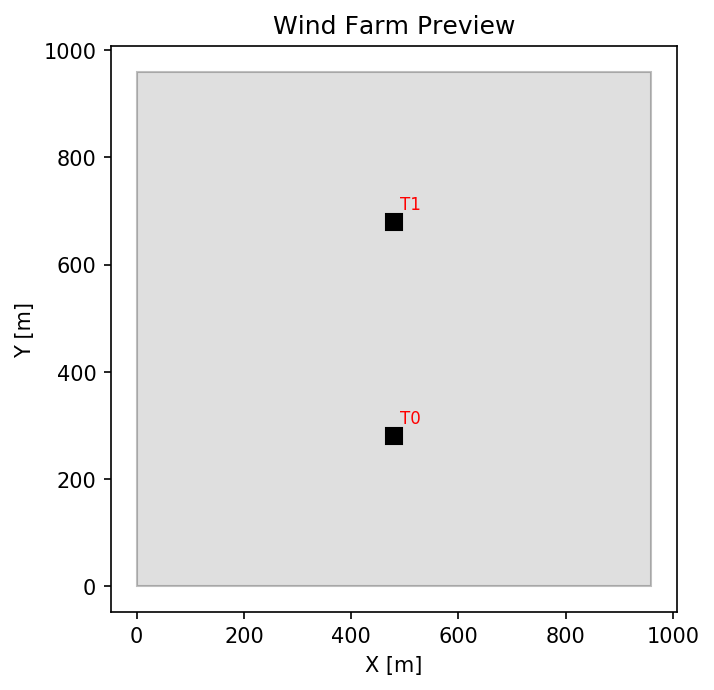

In [7]:
# Preview the turbine layout
fig, ax = plt.subplots(figsize=(5,5), facecolor='w', dpi=150)
case.turbines_previewAllTurbines(ax=ax)

In this next step, we tell it to actually create the turbines specified in the CSV input.

In [8]:
case.turbines_createAllTurbines()

# Print out existing list of turbines, just to confirm that the turbines got made
print(case.listboxpopupwindict['listboxactuator'].getitemlist())

['T0', 'T1']


## Create wind farm refinement zones  

Now around each turbine, we'll add some refinement zones so the
turbine rotors can be resolved.  Similar to the turbine
specifications, we can specify all of the refinement zones through CSV
input.  Here the `refine_csvtextbox` variable can be used to hold the
string input, while `loadRefineCSVFile()` can be used to read a CSV
file.  

In [9]:
refinementcsv="""
# CSV file should have columns with
# level, upstream, downstream, lateral, below, above, options
level, upstream, downstream, lateral, below, above, options
0,     1,    1,   1,   0.75, 1,
1,     0.5,  0.5, 0.5, 0.75, 1,
"""
case.setAMRWindInput('refine_csvtextbox', refinementcsv)
case.setAMRWindInput('refine_deleteprev', True)

The specifications for the CSV columns are given below, along
with some optional parameters:

### REFINEMENT SPECIFICATIONS

| column       | description                                                      | required/optional |
| ---          | ---                                                              | ---               |
| `level`      | The mesh level to apply the refinement.                          | required          |
| `upstream`   | The number of diameters or meters upstream to apply refinement   | required          |
| `downstream` | The number of diameters or meters downstream to apply refinement | required          |
| `lateral`    | The number of diameters or meters off to side of each turbine    | required          |
| `below`      | The number of diameters or meters below the turbine hub-height   | required          |
| `above`      | The number of diameters or meters above the turbine hub-height   | required          |
| `options`    | Any additional options (see below)                               | optional          |

### OPTIONAL INPUTS
| keyword       | default    | possible values               | description                                          |
| ---           | ---        | ---                           | ---                                                  |
| `orientation` | `winddir`  | `winddir`, `nacdir`, `x`, `y` | Which direction the refinement box should be pointed |
| `units`       | `diameter` | `diameter`, `meter`           | What units the values are in                         |
| `center`      | `turbine`  | `turbine`, `farm`             | Where the center of the refinement zone is located   |


To create the actual refinement zones in the domain, use the
`refine_createAllZones()` method.

In [10]:
case.refine_createAllZones()
# Print out existing list of turbines
print(case.listboxpopupwindict['listboxtagging'].getitemlist())

['T0_level_0_zone', 'T1_level_0_zone', 'T0_level_1_zone', 'T1_level_1_zone']


Now let's plot the turbine layouts using the plotDomain()
method.

Plotting turbines


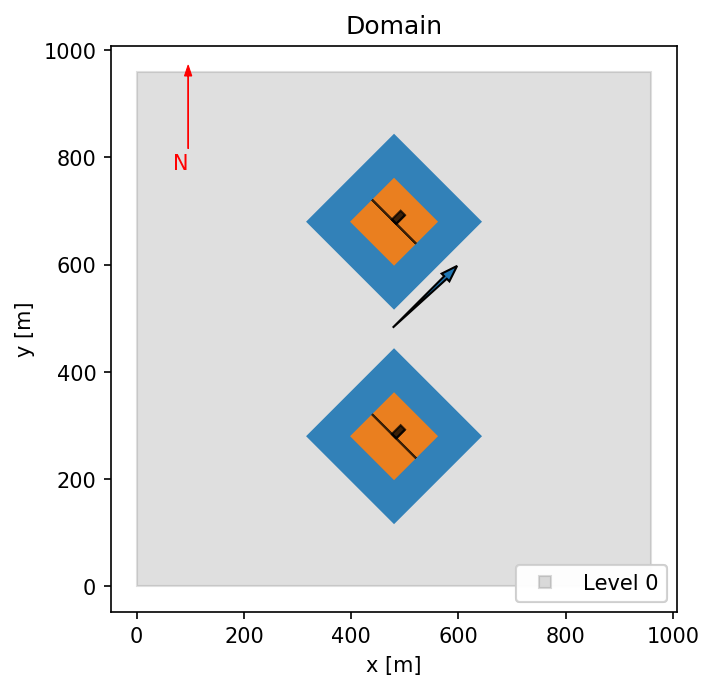

In [11]:
# Plot the domain
fig, ax = plt.subplots(figsize=(5,5), facecolor='w', dpi=150)
case.popup_storteddata['plotdomain']['plot_turbines']        = case.listboxpopupwindict['listboxactuator'].getitemlist()
case.popup_storteddata['plotdomain']['plot_refineboxes']     = case.listboxpopupwindict['listboxtagging'].getitemlist()
case.plotDomain(ax=ax)

## Create sampling planes

Now that we have the refinement zones specified, we'd like to add some
sampling probes in front of every turbine, and also for the wind farm
as a whole.

Here the `samplingcsv` variable will be used to hold the
specifications for all of the things we'd like to plot.

In [12]:
samplingcsv="""
# CSV file should have columns withturbinescsv=
# name, type, upstream, downstream, lateral, below, above, n1, n2, options
name, type, upstream, downstream, lateral, below, above, n1, n2, options
cl1, centerline, 1,  0, none, none,  none,  11, 11, none
rp1, rotorplane, 2,  0, none, none,  none,  11, 11, none
sw1, streamwise, 2,  1, 1, 0.5,  0.5,  11, 11, usedx:0.25 noffsets:1
hh,  hubheight,  2,  1, 1, 0,  none,  11, 11, usedx:0.25 center:farm orientation:x
"""
case.setAMRWindInput('sampling_csvtextbox', samplingcsv)
case.setAMRWindInput('sampling_deleteprev', True)

The definitions for each of the columns and the possible options
are given in the tables below:

### REFINEMENT SPECIFICATIONS

| column       | description                                                      | required/optional |
| ---          | ---                                                              | ---               |
| `level`      | The mesh level to apply the refinement.                          | required          |
| `upstream`   | The number of diameters or meters upstream to apply refinement   | required          |
| `downstream` | The number of diameters or meters downstream to apply refinement | required          |
| `lateral`    | The number of diameters or meters off to side of each turbine    | required          |
| `below`      | The number of diameters or meters below the turbine hub-height   | required          |
| `above`      | The number of diameters or meters above the turbine hub-height   | required          |
| `options`    | Any additional options (see below)                               | optional          |

### OPTIONAL INPUTS
| keyword       | default    | possible values               | description                                          |
| ---           | ---        | ---                           | ---                                                  |
| `orientation` | `winddir`  | `winddir`, `nacdir`, `x`, `y` | Which direction the refinement box should be pointed |
| `units`       | `diameter` | `diameter`, `meter`           | What units the values are in                         |
| `center`      | `turbine`  | `turbine`, `farm`             | Where the center of the refinement zone is located   |


Now let's create the sampling probes using the
`sampling_createAllProbes()` method.


In [13]:
case.sampling_createAllProbes(verbose=False)
# Print out existing list of turbines
print(case.listboxpopupwindict['listboxsampling'].getitemlist())

['T0_cl1', 'T1_cl1', 'T0_rp1', 'T1_rp1', 'T0_sw1', 'T1_sw1', 'Farm_hh']


Now to plot the domain we'll use the use the `plotDomain()` method again:

Plotting turbines


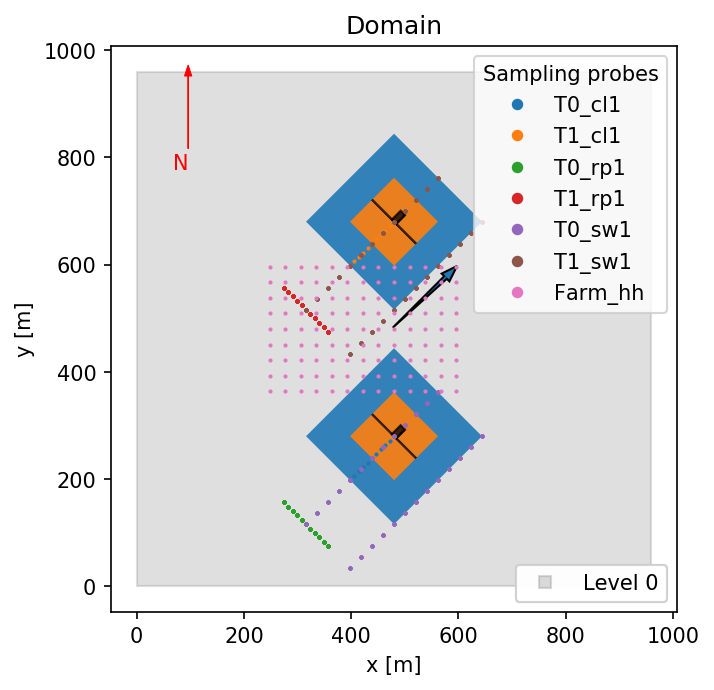

In [14]:
# Plot the domain
fig, ax = plt.subplots(figsize=(5,5), facecolor='w', dpi=150)
case.popup_storteddata['plotdomain']['plot_refineboxes']     = case.listboxpopupwindict['listboxtagging'].getitemlist()
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = case.listboxpopupwindict['listboxsampling'].getitemlist()
case.plotDomain(ax=ax)


## Set up a wind sweep

The above instructions were to set up a single case with one wind
speed (10 m/s) and one wind direction (225) degrees.  Now we'll
show what happens when you want to vary these to run a parameter
sweep. 


In [15]:
case.setAMRWindInput('sweep_windspeeds', '10 20')
case.setAMRWindInput('sweep_winddirs', '270 225')
case.setAMRWindInput('sweep_caseprefix', 'Tutorial3_Case_{CASENUM}')
case.setAMRWindInput('sweep_usenewdirs', False)
case.setAMRWindInput('sweep_logfile', 'Tutorial3_logfile.yaml')


To run the sweep, use the `sweep_SetupRunParamSweep()` call:


In [16]:
# Set up the cases
case.sweep_SetupRunParamSweep(verbose=True)

       NUM           WS         WDir            Case name
       ---           --         ----            ---------
         0     10.00000    270.00000     Tutorial3_Case_0
         1     10.00000    225.00000     Tutorial3_Case_1
         2     20.00000    270.00000     Tutorial3_Case_2
         3     20.00000    225.00000     Tutorial3_Case_3


We can check to make sure that the appropriate input files got
created:

In [17]:
# List the amr-wind input files
import glob
glob.glob('Tutorial3_Case_{CASENUM}'.format(CASENUM='*'))

['Tutorial3_Case_2.inp',
 'Tutorial3_Case_3.inp',
 'Tutorial3_Case_0.inp',
 'Tutorial3_Case_1.inp']


## Save the wind farm setup

After doing all of this wind farm setup work, we can save all of these
settings so that they can be reloaded and modified for future use.


To do this we'll use the `writeFarmSetupYAML()` method, and also save
some comments into the file at the same time.


In [18]:
# Save the wind farm setup
case.setAMRWindInput('farm_usercomments', 'Tutorial3 wind farm setup parameters.')
case.writeFarmSetupYAML('Tutorial3_WindFarmSetup.yaml')

Saved farm setup to Tutorial3_WindFarmSetup.yaml
